<a href="https://colab.research.google.com/github/Shub2204/TSF/blob/main/Banana_Disease_Detetction_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Extracting Zipped File

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
zip_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/BLD_Dataset.zip"

In [ ]:
import zipfile
import os

# Define the extraction path
extract_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train"

# Create the directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

## Importing Libraries

In [2]:
!pip install mahotas

In [3]:
## IMPORTING LIBRARIES
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import mahotas  # For NGTDM feature extraction
import pickle
import tensorflow as tf

from PIL import Image
from google.colab import drive
from tqdm import tqdm
from skimage.filters import threshold_otsu
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, average_precision_score, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize, StandardScaler
from google.colab import drive
from skimage.feature import graycomatrix, graycoprops  # For GLCM functions
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from tensorflow.keras.preprocessing import image_dataset_from_directory
from collections import Counter

## Verifying Datasets

In [5]:
# Path to your dataset inside Google Drive
base_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Dataset"

# Verify the dataset path
if not os.path.exists(base_dir):
    print("Error: Dataset path does not exist. Check your Google Drive path!")
else:
    # List all subfolders (each representing a disease class)
    disease_classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    print("Found Classes:", disease_classes)

    # Loop over each disease folder
    for disease_class in disease_classes:
        class_path = os.path.join(base_dir, disease_class)
        image_files = os.listdir(class_path)

        print(f"\nProcessing Class: {disease_class}")
        print(f"Number of images: {len(image_files)}")

        # Loop over each image in the disease folder
        for img_name in image_files:
            img_path = os.path.join(class_path, img_name)

            # Read the image (OpenCV reads in BGR format)
            img = cv2.imread(img_path)

            if img is not None:
                # Example: print shape to confirm successful load
                print(f"  - {img_name} | shape: {img.shape}")
            else:
                print(f"  - Could not read {img_name}")

Streaming output truncated to the last 5000 lines.
  - aug_0_4821.jpg | shape: (256, 256, 3)
  - aug_0_4844.jpg | shape: (256, 256, 3)
  - aug_0_4856.jpg | shape: (256, 256, 3)
  - aug_0_4897.jpg | shape: (256, 256, 3)
  - aug_0_49.jpg | shape: (256, 256, 3)
  - aug_0_4918.jpg | shape: (256, 256, 3)
  - aug_0_4919.jpg | shape: (256, 256, 3)
  - aug_0_4920.jpg | shape: (256, 256, 3)
  - aug_0_4924.jpg | shape: (256, 256, 3)
  - aug_0_4971.jpg | shape: (256, 256, 3)
  - aug_0_4981.jpg | shape: (256, 256, 3)
  - aug_0_5030.jpg | shape: (256, 256, 3)
  - aug_0_5058.jpg | shape: (256, 256, 3)
  - aug_0_506.jpg | shape: (256, 256, 3)
  - aug_0_5068.jpg | shape: (256, 256, 3)
  - aug_0_5076.jpg | shape: (256, 256, 3)
  - aug_0_5095.jpg | shape: (256, 256, 3)
  - aug_0_5118.jpg | shape: (256, 256, 3)
  - aug_0_5181.jpg | shape: (256, 256, 3)
  - aug_0_5190.jpg | shape: (256, 256, 3)
  - aug_0_5193.jpg | shape: (256, 256, 3)
  - aug_0_5214.jpg | shape: (256, 256, 3)
  - aug_0_5227.jpg | shape: 

## Resizing Image Datasets to 224*224

In [6]:
# Set base directories (Change paths as needed)
base_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Dataset"
resized_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Resized_Dataset"  # Folder to save resized images

# Create the resized dataset directory if it doesn't exist
os.makedirs(resized_dir, exist_ok=True)

# List all disease classes
disease_classes = os.listdir(base_dir)
print("Found Classes:", disease_classes)

# Function to apply aspect ratio-preserving padding
def resize_with_padding(image, target_size=224):
    h, w, c = image.shape  # Get original dimensions

    # Calculate padding (if needed)
    pad_top = pad_bottom = pad_left = pad_right = 0

    if h < target_size or w < target_size:
        # Calculate how much padding is needed to make the image square
        max_dim = max(h, w)
        pad_top = (max_dim - h) // 2
        pad_bottom = max_dim - h - pad_top
        pad_left = (max_dim - w) // 2
        pad_right = max_dim - w - pad_left

        # Add padding with black (zero pixels)
        image = cv2.copyMakeBorder(image, pad_top, pad_bottom, pad_left, pad_right,
                                   cv2.BORDER_CONSTANT, value=(0, 0, 0))  # Black padding

    # Resize the padded image to 224x224
    resized_image = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_AREA)
    return resized_image

# Loop through each disease class and resize images
for disease_class in disease_classes:
    class_path = os.path.join(base_dir, disease_class)

    if os.path.isdir(class_path):
        save_class_path = os.path.join(resized_dir, disease_class)
        os.makedirs(save_class_path, exist_ok=True)

        image_files = os.listdir(class_path)
        print(f"\nProcessing Class: {disease_class}, Total images: {len(image_files)}")

        for img_name in tqdm(image_files):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                resized_img = resize_with_padding(img)  # Apply aspect-ratio-preserving padding & resizing

                # Save the resized image
                save_path = os.path.join(save_class_path, img_name)
                cv2.imwrite(save_path, resized_img)
            else:
                print(f"Warning: Could not read {img_name}")

Found Classes: ['Aphids', 'Black_Singatoka', 'Bract_Mosaic', 'Cordana', 'Fusarium_Wilt', 'healthy', 'Insect_Pest', 'Moko', 'Pestalotiopsis', 'Pseudostem_Weevil', 'Scarring_Beetle', 'Soft_Rot', 'Xamthomonas', 'Yellow_Singatoka']

Processing Class: Aphids, Total images: 520


100%|██████████| 520/520 [00:12<00:00, 42.16it/s] 



Processing Class: Black_Singatoka, Total images: 865


100%|██████████| 865/865 [02:44<00:00,  5.27it/s]



Processing Class: Bract_Mosaic, Total images: 585


100%|██████████| 585/585 [00:16<00:00, 35.79it/s]



Processing Class: Cordana, Total images: 795


100%|██████████| 795/795 [00:28<00:00, 28.30it/s]



Processing Class: Fusarium_Wilt, Total images: 844


100%|██████████| 844/844 [03:38<00:00,  3.87it/s]



Processing Class: healthy, Total images: 769


100%|██████████| 769/769 [00:23<00:00, 32.16it/s]



Processing Class: Insect_Pest, Total images: 589


100%|██████████| 589/589 [00:19<00:00, 29.82it/s]



Processing Class: Moko, Total images: 648


100%|██████████| 648/648 [00:30<00:00, 21.28it/s]



Processing Class: Pestalotiopsis, Total images: 841


100%|██████████| 841/841 [00:24<00:00, 33.73it/s]



Processing Class: Pseudostem_Weevil, Total images: 811


100%|██████████| 811/811 [00:26<00:00, 30.75it/s]



Processing Class: Scarring_Beetle, Total images: 626


100%|██████████| 626/626 [00:17<00:00, 34.88it/s]



Processing Class: Soft_Rot, Total images: 987


100%|██████████| 987/987 [00:33<00:00, 29.89it/s]



Processing Class: Xamthomonas, Total images: 801


100%|██████████| 801/801 [00:39<00:00, 20.52it/s]



Processing Class: Yellow_Singatoka, Total images: 500


100%|██████████| 500/500 [00:15<00:00, 32.98it/s]


## Preprocessing Images

In [7]:
# Set paths to your dataset folders on Google Drive
resized_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Resized_Dataset"  # Folder with resized images (e.g., 224×224)
preprocessed_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Preprocessed_Grayscaled_Dataset"  # Folder to save preprocessed images

os.makedirs(preprocessed_dir, exist_ok=True)

def advanced_preprocess(img, to_grayscale=False, gaussian_kernel=5, apply_otsu=False, normalize=True):
    """
    Perform grayscale conversion, Gaussian blur, Otsu's thresholding,
    and normalization on an input image.
    """
    processed_img = img.copy()

    # 1. Convert to Grayscale (Optional)
    if to_grayscale:
        processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
        # Stack to retain 3 channels for consistent shape
        processed_img = np.stack([processed_img] * 3, axis=-1)

    # 2. Apply Gaussian Blur (Noise Reduction)
    processed_img = cv2.GaussianBlur(processed_img, (gaussian_kernel, gaussian_kernel), 0)

    # 3. Otsu’s Thresholding for Background Removal (Optional)
    if apply_otsu:
        gray_for_otsu = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
        thresh_val = threshold_otsu(gray_for_otsu)
        mask = (gray_for_otsu > thresh_val).astype(np.uint8)
        # Zero-out the background (mask == 0)
        processed_img[mask == 0] = 0

    # 4. Normalize pixel values to [0, 1]
    if normalize:
        processed_img = processed_img.astype(np.float32) / 255.0

    return processed_img

# Process each disease class folder in the resized dataset
disease_classes = os.listdir(resized_dir)
print("Found Classes:", disease_classes)

for disease_class in disease_classes:
    class_path = os.path.join(resized_dir, disease_class)

    if os.path.isdir(class_path):
        # Create corresponding folder in the preprocessed directory
        save_class_path = os.path.join(preprocessed_dir, disease_class)
        os.makedirs(save_class_path, exist_ok=True)

        image_files = os.listdir(class_path)
        print(f"\nPreprocessing Class: {disease_class}, Images: {len(image_files)}")

        for img_name in tqdm(image_files):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                # Apply advanced preprocessing with chosen parameters
                processed_img = advanced_preprocess(
                    img,
                    to_grayscale=True,    # Convert image to grayscale (and stack to 3 channels)
                    gaussian_kernel=5,    # Kernel size for Gaussian blur
                    apply_otsu=True,      # Apply Otsu's thresholding for background removal
                    normalize=True        # Normalize the pixel values
                )

                # Convert back to uint8 (if saving to disk as image)
                saved_img = (processed_img * 255).astype(np.uint8)
                save_path = os.path.join(save_class_path, img_name)
                cv2.imwrite(save_path, saved_img)
            else:
                print(f"Could not read {img_name}")

Found Classes: ['Black_Singatoka', 'Bract_Mosaic', 'Cordana', 'Fusarium_Wilt', 'healthy', 'Insect_Pest', 'Moko', 'Pestalotiopsis', 'Pseudostem_Weevil', 'Scarring_Beetle', 'Soft_Rot', 'Xamthomonas', 'Yellow_Singatoka']

Preprocessing Class: Black_Singatoka, Images: 865


100%|██████████| 865/865 [00:24<00:00, 35.46it/s]



Preprocessing Class: Bract_Mosaic, Images: 585


100%|██████████| 585/585 [00:16<00:00, 35.43it/s]



Preprocessing Class: Cordana, Images: 795


100%|██████████| 795/795 [00:23<00:00, 34.55it/s]



Preprocessing Class: Fusarium_Wilt, Images: 844


100%|██████████| 844/844 [00:23<00:00, 35.99it/s]



Preprocessing Class: healthy, Images: 769


100%|██████████| 769/769 [00:20<00:00, 37.34it/s]



Preprocessing Class: Insect_Pest, Images: 589


100%|██████████| 589/589 [00:19<00:00, 30.96it/s]



Preprocessing Class: Moko, Images: 648


100%|██████████| 648/648 [00:22<00:00, 28.59it/s]



Preprocessing Class: Pestalotiopsis, Images: 841


100%|██████████| 841/841 [00:27<00:00, 30.46it/s]



Preprocessing Class: Pseudostem_Weevil, Images: 811


100%|██████████| 811/811 [00:25<00:00, 31.89it/s]



Preprocessing Class: Scarring_Beetle, Images: 626


100%|██████████| 626/626 [00:15<00:00, 40.55it/s]



Preprocessing Class: Soft_Rot, Images: 987


100%|██████████| 987/987 [00:27<00:00, 35.58it/s]



Preprocessing Class: Xamthomonas, Images: 801


100%|██████████| 801/801 [00:19<00:00, 41.96it/s]



Preprocessing Class: Yellow_Singatoka, Images: 500


100%|██████████| 500/500 [00:11<00:00, 43.59it/s]


In [8]:
# Set paths to your dataset folders on Google Drive
resized_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Resized_Dataset"  # Folder with resized images (e.g., 224×224)
preprocessed_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Preprocessed_wo_grayotsu_Dataset"  # Folder to save preprocessed images

os.makedirs(preprocessed_dir, exist_ok=True)

def advanced_preprocess(img, to_grayscale=False, gaussian_kernel=5, apply_otsu=False, normalize=True):
    """
    Perform Gaussian blur and normalization on an input image.
    """
    processed_img = img.copy()

    # 1. Convert to Grayscale (Optional)
    if to_grayscale:
        processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
        # Stack to retain 3 channels for consistent shape
        processed_img = np.stack([processed_img] * 3, axis=-1)

    # 2. Apply Gaussian Blur (Noise Reduction)
    processed_img = cv2.GaussianBlur(processed_img, (gaussian_kernel, gaussian_kernel), 0)

    # 3. Otsu’s Thresholding for Background Removal (Optional)
    if apply_otsu:
        gray_for_otsu = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
        thresh_val = threshold_otsu(gray_for_otsu)
        mask = (gray_for_otsu > thresh_val).astype(np.uint8)
        # Zero-out the background (mask == 0)
        processed_img[mask == 0] = 0

    # 4. Normalize pixel values to [0, 1]
    if normalize:
        processed_img = processed_img.astype(np.float32) / 255.0

    return processed_img

# Process each disease class folder in the resized dataset
disease_classes = os.listdir(resized_dir)
print("Found Classes:", disease_classes)

for disease_class in disease_classes:
    class_path = os.path.join(resized_dir, disease_class)

    if os.path.isdir(class_path):
        # Create corresponding folder in the preprocessed directory
        save_class_path = os.path.join(preprocessed_dir, disease_class)
        os.makedirs(save_class_path, exist_ok=True)

        image_files = os.listdir(class_path)
        print(f"\nPreprocessing Class: {disease_class}, Images: {len(image_files)}")

        for img_name in tqdm(image_files):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                # Apply advanced preprocessing with chosen parameters
                processed_img = advanced_preprocess(
                    img,
                    to_grayscale=False,    # Convert image to grayscale (and stack to 3 channels)
                    gaussian_kernel=5,    # Kernel size for Gaussian blur
                    apply_otsu=False,      # Apply Otsu's thresholding for background removal
                    normalize=True        # Normalize the pixel values
                )

                # Convert back to uint8 (if saving to disk as image)
                saved_img = (processed_img * 255).astype(np.uint8)
                save_path = os.path.join(save_class_path, img_name)
                cv2.imwrite(save_path, saved_img)
            else:
                print(f"Could not read {img_name}")

Found Classes: ['Black_Singatoka', 'Bract_Mosaic', 'Cordana', 'Fusarium_Wilt', 'healthy', 'Insect_Pest', 'Moko', 'Pestalotiopsis', 'Pseudostem_Weevil', 'Scarring_Beetle', 'Soft_Rot', 'Xamthomonas', 'Yellow_Singatoka']

Preprocessing Class: Black_Singatoka, Images: 865


100%|██████████| 865/865 [00:19<00:00, 43.86it/s]



Preprocessing Class: Bract_Mosaic, Images: 585


100%|██████████| 585/585 [00:11<00:00, 50.74it/s]



Preprocessing Class: Cordana, Images: 795


100%|██████████| 795/795 [00:16<00:00, 48.00it/s]



Preprocessing Class: Fusarium_Wilt, Images: 844


100%|██████████| 844/844 [00:16<00:00, 49.86it/s]



Preprocessing Class: healthy, Images: 769


100%|██████████| 769/769 [00:15<00:00, 49.69it/s]



Preprocessing Class: Insect_Pest, Images: 589


100%|██████████| 589/589 [00:11<00:00, 52.39it/s]



Preprocessing Class: Moko, Images: 648


100%|██████████| 648/648 [00:12<00:00, 50.34it/s]



Preprocessing Class: Pestalotiopsis, Images: 841


100%|██████████| 841/841 [00:17<00:00, 49.00it/s]



Preprocessing Class: Pseudostem_Weevil, Images: 811


100%|██████████| 811/811 [00:16<00:00, 47.78it/s]



Preprocessing Class: Scarring_Beetle, Images: 626


100%|██████████| 626/626 [00:12<00:00, 50.25it/s]



Preprocessing Class: Soft_Rot, Images: 987


100%|██████████| 987/987 [00:19<00:00, 49.90it/s]



Preprocessing Class: Xamthomonas, Images: 801


100%|██████████| 801/801 [00:15<00:00, 51.85it/s]



Preprocessing Class: Yellow_Singatoka, Images: 500


100%|██████████| 500/500 [00:08<00:00, 57.54it/s]


## Exploratory Data Analysis

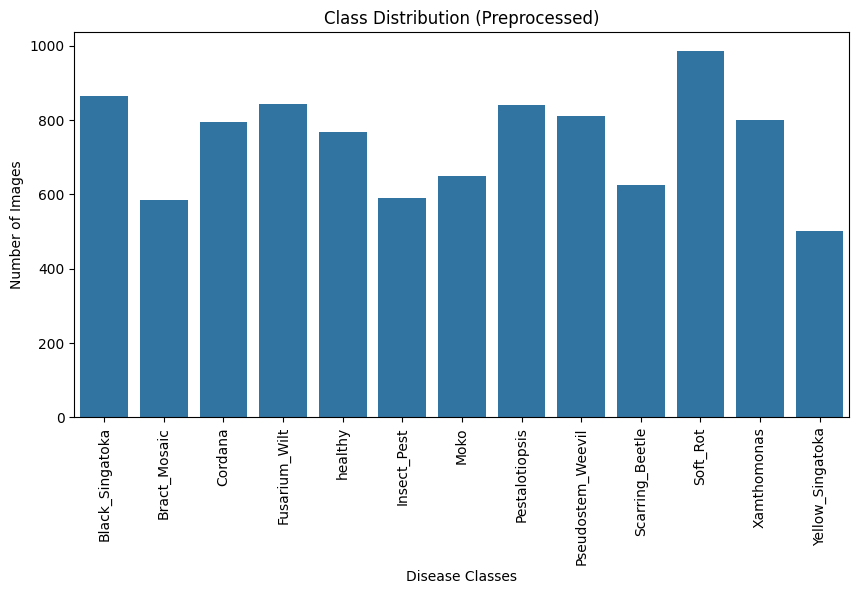

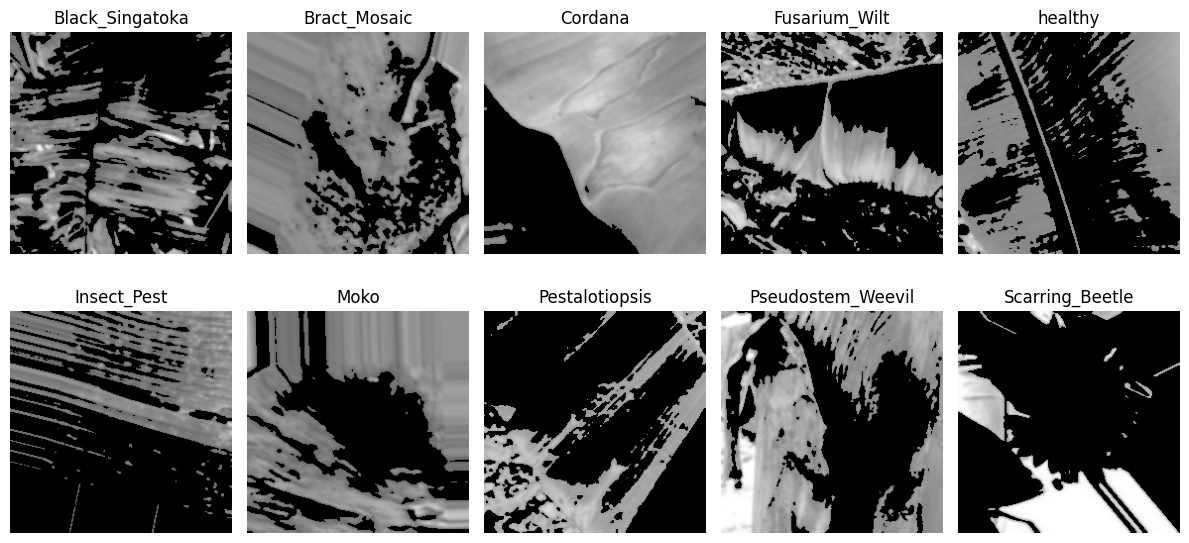

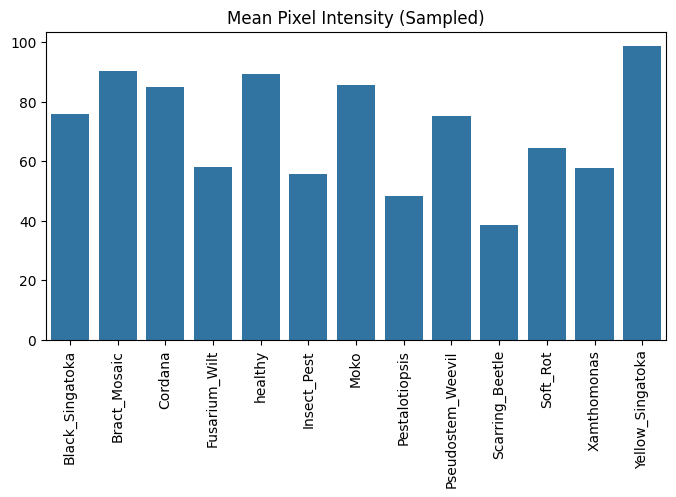

In [9]:
# Set base_dir to your preprocessed dataset path in Google Drive
base_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Preprocessed_Grayscaled_Dataset"

# 1. Class distribution
disease_classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
class_counts = {}
for disease_class in disease_classes:
    class_path = os.path.join(base_dir, disease_class)
    image_files = os.listdir(class_path)
    class_counts[disease_class] = len(image_files)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.xlabel("Disease Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution (Preprocessed)")
plt.show()

# 2. Show sample images per class (display first image from first 10 classes)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()
for i, disease_class in enumerate(disease_classes[:10]):
    class_path = os.path.join(base_dir, disease_class)
    image_files = os.listdir(class_path)
    if len(image_files) > 0:
        img_path = os.path.join(class_path, image_files[0])
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(disease_class)
        axes[i].axis("off")
plt.tight_layout()
plt.show()

# 3. Mean pixel intensities (sample 5 images per class)
mean_intensities = []
for disease_class in disease_classes:
    class_path = os.path.join(base_dir, disease_class)
    image_files = os.listdir(class_path)

    if len(image_files) == 0:
        mean_intensities.append(0)
        continue

    total_intensity = 0
    sample_count = min(5, len(image_files))
    for img_name in image_files[:sample_count]:
        img_path = os.path.join(class_path, img_name)
        img = np.array(Image.open(img_path))
        total_intensity += img.mean()

    mean_intensity_class = total_intensity / sample_count
    mean_intensities.append(mean_intensity_class)

plt.figure(figsize=(8, 4))
sns.barplot(x=disease_classes, y=mean_intensities)
plt.xticks(rotation=90)
plt.title("Mean Pixel Intensity (Sampled)")
plt.show()

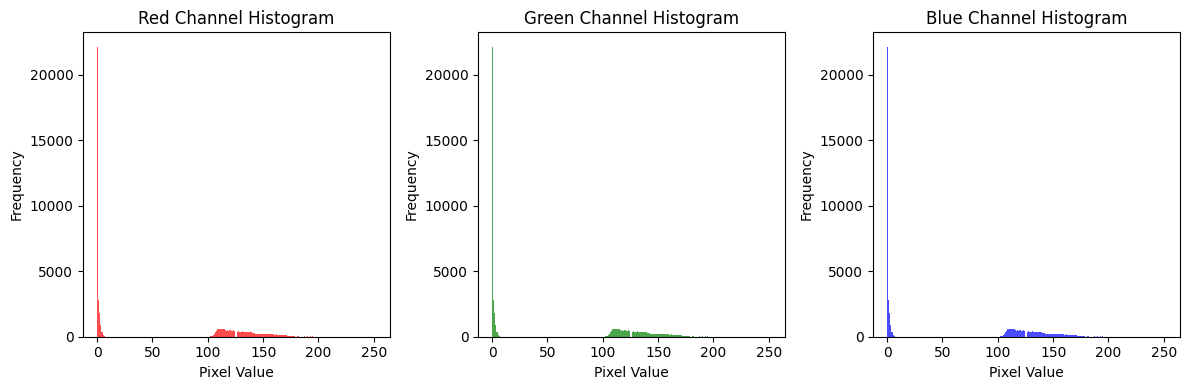

In [10]:
### HISTOGRAM OF PIXEL VALUES
# Set base directory (adjust the path as needed)
base_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Preprocessed_Grayscaled_Dataset"
disease_classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
sample_class = disease_classes[0]  # choose the first class
sample_img_path = os.path.join(base_dir, sample_class, os.listdir(os.path.join(base_dir, sample_class))[0])
img = np.array(Image.open(sample_img_path))

plt.figure(figsize=(12, 4))
colors = ['red', 'green', 'blue']
for i, color in enumerate(colors):
    plt.subplot(1, 3, i+1)
    plt.hist(img[:, :, i].ravel(), bins=256, color=color, alpha=0.7)
    plt.title(f'{color.capitalize()} Channel Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

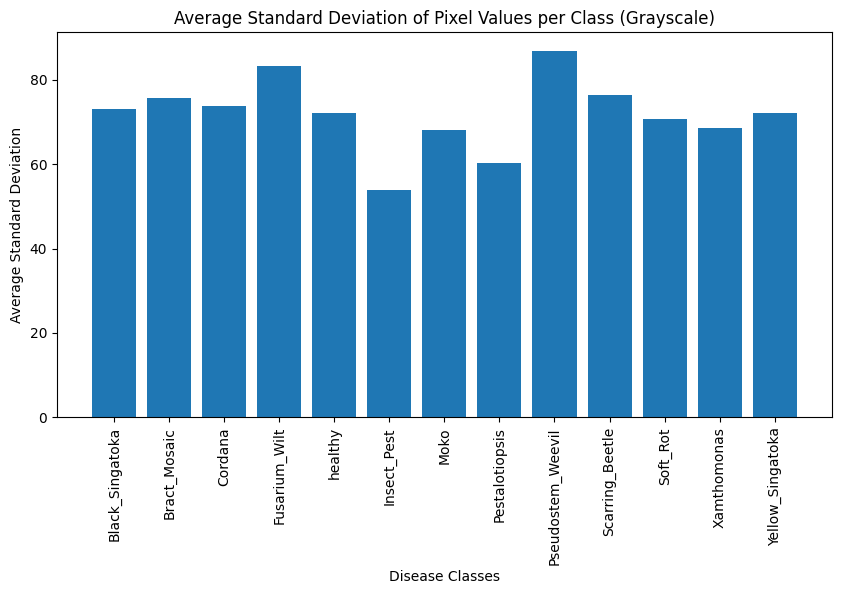

In [11]:
### STD DEVIATION OF PIXEL VALUES PER CLASS

base_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Preprocessed_Grayscaled_Dataset"
disease_classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
class_std = {}

for disease_class in disease_classes:
    class_path = os.path.join(base_dir, disease_class)
    image_files = os.listdir(class_path)
    if len(image_files) == 0:
        continue
    stds = []
    sample_count = min(5, len(image_files))
    for img_name in image_files[:sample_count]:
        img_path = os.path.join(class_path, img_name)
        # Convert image to grayscale
        img = np.array(Image.open(img_path).convert('L'))
        stds.append(np.std(img))
    class_std[disease_class] = np.mean(stds)

plt.figure(figsize=(10, 5))
plt.bar(list(class_std.keys()), list(class_std.values()))
plt.xticks(rotation=90)
plt.xlabel("Disease Classes")
plt.ylabel("Average Standard Deviation")
plt.title("Average Standard Deviation of Pixel Values per Class (Grayscale)")
plt.show()

In [12]:
## Image Quality Metrics (Contrast, Brightness, and Sharpness)

# Select a sample image from the first class
disease_classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
sample_class = disease_classes[0]
sample_img_path = os.path.join(base_dir, sample_class, os.listdir(os.path.join(base_dir, sample_class))[0])
img = cv2.imread(sample_img_path)

# Convert to grayscale for analysis
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Calculate brightness as the mean pixel intensity
brightness = np.mean(gray)

# Calculate contrast as the standard deviation of pixel intensities
contrast = np.std(gray)

# Calculate sharpness using the variance of the Laplacian
sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()

print("Brightness (mean pixel intensity):", brightness)
print("Contrast (std of pixel intensities):", contrast)
print("Sharpness (variance of Laplacian):", sharpness)

Brightness (mean pixel intensity): 58.350566007653065
Contrast (std of pixel intensities): 66.97286783457189
Sharpness (variance of Laplacian): 4927.3957566241825


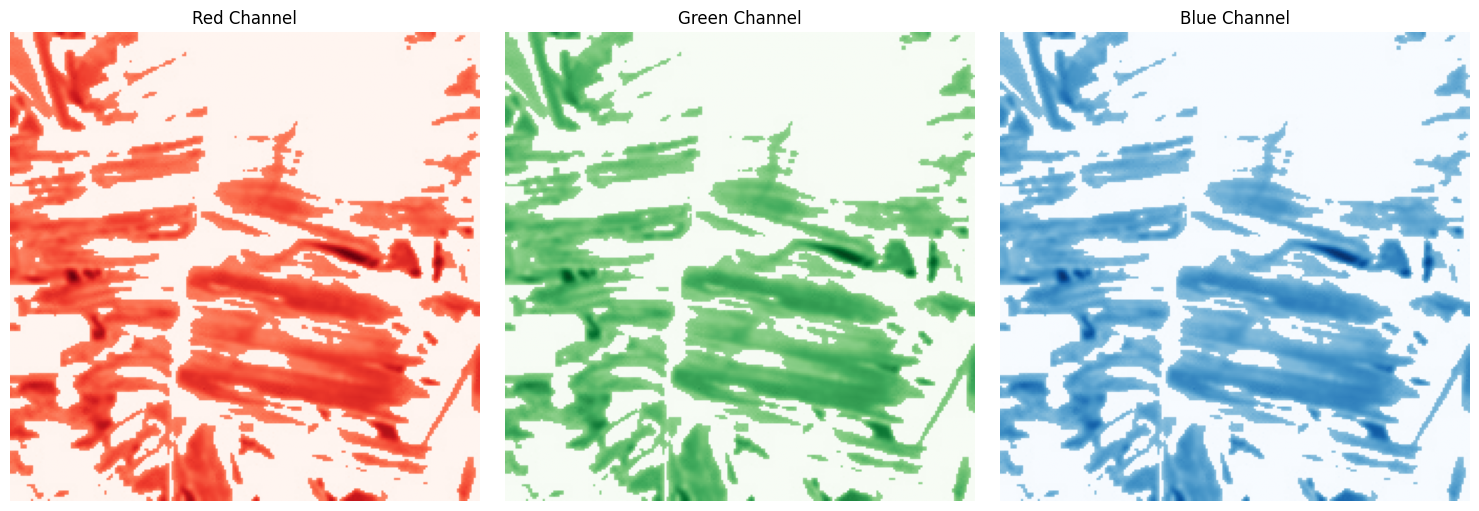

In [13]:
## CHANNEL WISE ANALYSIS

disease_classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
sample_class = disease_classes[0]
sample_img_path = os.path.join(base_dir, sample_class, os.listdir(os.path.join(base_dir, sample_class))[0])
img = np.array(Image.open(sample_img_path))

# Extract individual channels
red_channel = img[:, :, 0]
green_channel = img[:, :, 1]
blue_channel = img[:, :, 2]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(red_channel, cmap='Reds')
plt.title("Red Channel")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(green_channel, cmap='Greens')
plt.title("Green Channel")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(blue_channel, cmap='Blues')
plt.title("Blue Channel")
plt.axis("off")

plt.tight_layout()
plt.show()

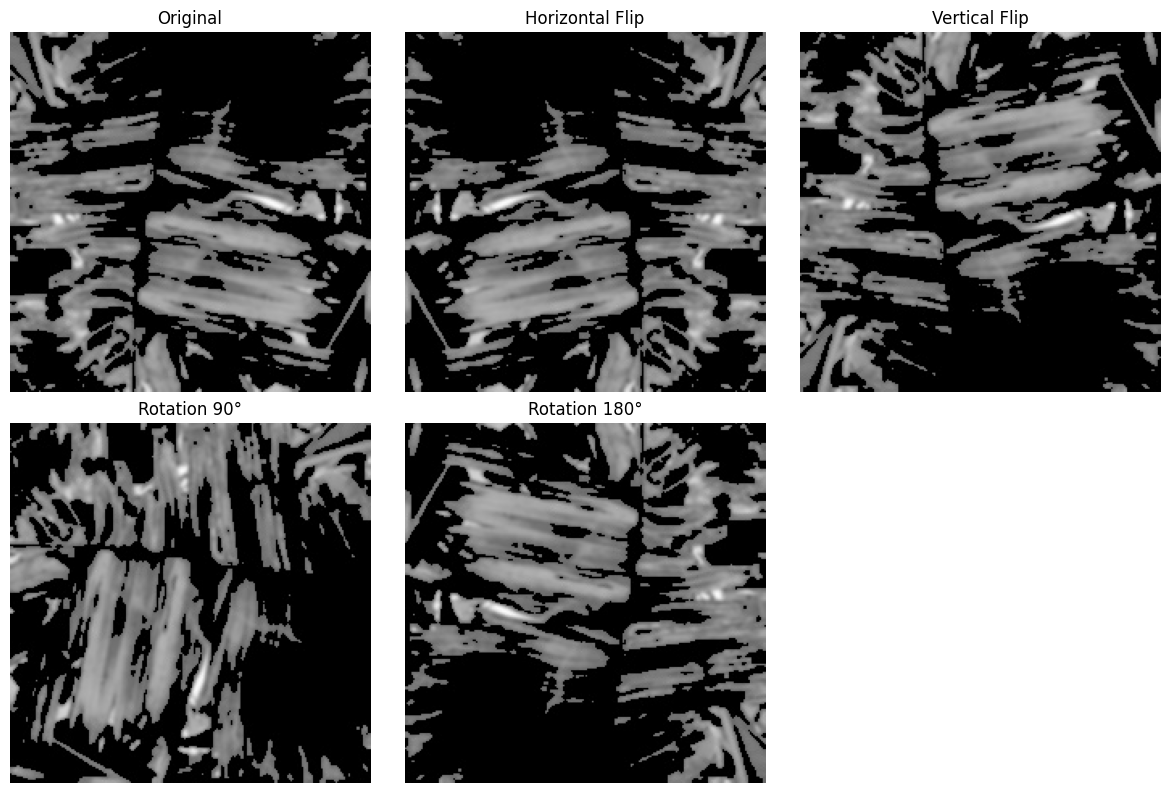

In [14]:
## DATA Augmentation Visualization

# Select a sample image from the dataset
disease_classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
sample_class = disease_classes[0]
sample_img_path = os.path.join(base_dir, sample_class, os.listdir(os.path.join(base_dir, sample_class))[0])
img = cv2.imread(sample_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

# Apply augmentations:
hflip = cv2.flip(img, 1)             # Horizontal flip
vflip = cv2.flip(img, 0)             # Vertical flip
rot90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)  # Rotate 90 degrees
rot180 = cv2.rotate(img, cv2.ROTATE_180)           # Rotate 180 degrees

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(hflip)
plt.title("Horizontal Flip")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.imshow(vflip)
plt.title("Vertical Flip")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.imshow(rot90)
plt.title("Rotation 90°")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(rot180)
plt.title("Rotation 180°")
plt.axis("off")

plt.tight_layout()
plt.show()

## Model 1: Random Forest (Base Model)

In [18]:
# 1. Define dataset path
dataset_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Resized_Dataset"

# 2. Load images & labels
X = []  # Features
y = []  # Labels
labels_dict = {}  # Map folder names to numeric labels
label_counter = 0

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        if folder not in labels_dict:
            labels_dict[folder] = label_counter
            label_counter += 1
        label = labels_dict[folder]

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                continue  # Skip unreadable images
            img = cv2.resize(img, (224, 224))  # Resize image
            img = img.flatten()  # Flatten to 1D feature vector
            X.append(img)
            y.append(label)

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# 3. Train-test split (80% train, 20% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 4. Implement Two-Stage Classification
# Stage 1: Binary Classification (Healthy vs Unhealthy)
# Assume label 0 = Healthy, and all other labels are Unhealthy
y_train_stage1 = np.where(y_train == 0, 0, 1)  # 0 = Healthy, 1 = Unhealthy
y_test_stage1 = np.where(y_test == 0, 0, 1)

# Train Random Forest for Stage 1
rf_stage1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_stage1.fit(X_train, y_train_stage1)

# Predictions for Stage 1
y_pred_stage1_train = rf_stage1.predict(X_train)
y_pred_stage1_test = rf_stage1.predict(X_test)

print("\nStage 1 - Healthy vs Unhealthy Classification Report (Train):\n")
print(classification_report(y_train_stage1, y_pred_stage1_train, target_names=["Healthy", "Unhealthy"]))

print("\nStage 1 - Healthy vs Unhealthy Classification Report (Test):\n")
print(classification_report(y_test_stage1, y_pred_stage1_test, target_names=["Healthy", "Unhealthy"]))

# Stage 2: Multi-Class Disease Classification (Only for Unhealthy Leaves)
X_train_stage2 = X_train[y_train_stage1 == 1]  # Select only Unhealthy samples
y_train_stage2 = y_train[y_train_stage1 == 1]  # Keep original disease labels

X_test_stage2 = X_test[y_test_stage1 == 1]
y_test_stage2 = y_test[y_test_stage1 == 1]

# Train Random Forest for Stage 2
rf_stage2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_stage2.fit(X_train_stage2, y_train_stage2)

# Predictions for Stage 2
y_pred_stage2_train = rf_stage2.predict(X_train_stage2)
y_pred_stage2_test = rf_stage2.predict(X_test_stage2)

print("\nStage 2 - Disease Classification Report (Train):\n")
print(classification_report(y_train_stage2, y_pred_stage2_train, target_names=[k for k, v in labels_dict.items() if v != 0]))

print("\nStage 2 - Disease Classification Report (Test):\n")
print(classification_report(y_test_stage2, y_pred_stage2_test, target_names=[k for k, v in labels_dict.items() if v != 0]))

# 5. Save the model
model_save_path_stage1 = "/content/drive/MyDrive/LJMU_Research/Model/random_forest_Resized_stage1.pkl"
model_save_path_stage2 = "/content/drive/MyDrive/LJMU_Research/Model/random_forest_Resized_stage2.pkl"

joblib.dump(rf_stage1, model_save_path_stage1)
joblib.dump(rf_stage2, model_save_path_stage2)

print(f"Stage 1 Model saved at: {model_save_path_stage1}")
print(f"Stage 2 Model saved at: {model_save_path_stage2}")


Stage 1 - Healthy vs Unhealthy Classification Report (Train):

              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       692
   Unhealthy       1.00      1.00      1.00      7036

    accuracy                           1.00      7728
   macro avg       1.00      1.00      1.00      7728
weighted avg       1.00      1.00      1.00      7728


Stage 1 - Healthy vs Unhealthy Classification Report (Test):

              precision    recall  f1-score   support

     Healthy       1.00      0.04      0.08       173
   Unhealthy       0.91      1.00      0.95      1760

    accuracy                           0.91      1933
   macro avg       0.96      0.52      0.52      1933
weighted avg       0.92      0.91      0.88      1933


Stage 2 - Disease Classification Report (Train):

                   precision    recall  f1-score   support

     Bract_Mosaic       1.00      1.00      1.00       468
          Cordana       1.00      1.00      1.00 

In [17]:
# 1. Define dataset path
dataset_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Preprocessed_Grayscaled_Dataset"

# 2. Load images & labels
X = []  # Features
y = []  # Labels
labels_dict = {}  # Map folder names to numeric labels
label_counter = 0

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        if folder not in labels_dict:
            labels_dict[folder] = label_counter
            label_counter += 1
        label = labels_dict[folder]

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                continue  # Skip unreadable images
            img = cv2.resize(img, (224, 224))  # Resize image
            img = img.flatten()  # Flatten to 1D feature vector
            X.append(img)
            y.append(label)

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# 3. Train-test split (80% train, 20% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 4. Implement Two-Stage Classification
# Stage 1: Binary Classification (Healthy vs Unhealthy)
# Assume label 0 = Healthy, and all other labels are Unhealthy
y_train_stage1 = np.where(y_train == 0, 0, 1)  # 0 = Healthy, 1 = Unhealthy
y_test_stage1 = np.where(y_test == 0, 0, 1)

# Train Random Forest for Stage 1
rf_stage1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_stage1.fit(X_train, y_train_stage1)

# Predictions for Stage 1
y_pred_stage1_train = rf_stage1.predict(X_train)
y_pred_stage1_test = rf_stage1.predict(X_test)

print("\nStage 1 - Healthy vs Unhealthy Classification Report (Train):\n")
print(classification_report(y_train_stage1, y_pred_stage1_train, target_names=["Healthy", "Unhealthy"]))

print("\nStage 1 - Healthy vs Unhealthy Classification Report (Test):\n")
print(classification_report(y_test_stage1, y_pred_stage1_test, target_names=["Healthy", "Unhealthy"]))

# Stage 2: Multi-Class Disease Classification (Only for Unhealthy Leaves)
X_train_stage2 = X_train[y_train_stage1 == 1]  # Select only Unhealthy samples
y_train_stage2 = y_train[y_train_stage1 == 1]  # Keep original disease labels

X_test_stage2 = X_test[y_test_stage1 == 1]
y_test_stage2 = y_test[y_test_stage1 == 1]

# Train Random Forest for Stage 2
rf_stage2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_stage2.fit(X_train_stage2, y_train_stage2)

# Predictions for Stage 2
y_pred_stage2_train = rf_stage2.predict(X_train_stage2)
y_pred_stage2_test = rf_stage2.predict(X_test_stage2)

print("\nStage 2 - Disease Classification Report (Train):\n")
print(classification_report(y_train_stage2, y_pred_stage2_train, target_names=[k for k, v in labels_dict.items() if v != 0]))

print("\nStage 2 - Disease Classification Report (Test):\n")
print(classification_report(y_test_stage2, y_pred_stage2_test, target_names=[k for k, v in labels_dict.items() if v != 0]))

# 5. Save the model
model_save_path_stage1 = "/content/drive/MyDrive/LJMU_Research/Model/random_forest_Preprocessed_Grayscaled_stage1.pkl"
model_save_path_stage2 = "/content/drive/MyDrive/LJMU_Research/Model/random_forest_Preprocessed_Grayscaled_stage2.pkl"

joblib.dump(rf_stage1, model_save_path_stage1)
joblib.dump(rf_stage2, model_save_path_stage2)

print(f"Stage 1 Model saved at: {model_save_path_stage1}")
print(f"Stage 2 Model saved at: {model_save_path_stage2}")


Stage 1 - Healthy vs Unhealthy Classification Report (Train):

              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       692
   Unhealthy       1.00      1.00      1.00      7036

    accuracy                           1.00      7728
   macro avg       1.00      1.00      1.00      7728
weighted avg       1.00      1.00      1.00      7728


Stage 1 - Healthy vs Unhealthy Classification Report (Test):

              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00       173
   Unhealthy       0.91      1.00      0.95      1760

    accuracy                           0.91      1933
   macro avg       0.46      0.50      0.48      1933
weighted avg       0.83      0.91      0.87      1933



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Stage 2 - Disease Classification Report (Train):

                   precision    recall  f1-score   support

     Bract_Mosaic       1.00      1.00      1.00       468
          Cordana       1.00      1.00      1.00       636
    Fusarium_Wilt       1.00      1.00      1.00       675
          healthy       1.00      1.00      1.00       615
      Insect_Pest       1.00      1.00      1.00       471
             Moko       1.00      1.00      1.00       518
   Pestalotiopsis       1.00      1.00      1.00       673
Pseudostem_Weevil       0.98      0.98      0.98       649
  Scarring_Beetle       1.00      1.00      1.00       501
         Soft_Rot       0.98      0.98      0.98       789
      Xamthomonas       1.00      1.00      1.00       641
 Yellow_Singatoka       1.00      1.00      1.00       400

         accuracy                           1.00      7036
        macro avg       1.00      1.00      1.00      7036
     weighted avg       1.00      1.00      1.00      7036


S

In [19]:
# 1. Define dataset path
dataset_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Preprocessed_wo_grayotsu_Dataset"

# 2. Load images & labels
X = []  # Features
y = []  # Labels
labels_dict = {}  # Map folder names to numeric labels
label_counter = 0

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        if folder not in labels_dict:
            labels_dict[folder] = label_counter
            label_counter += 1
        label = labels_dict[folder]

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                continue  # Skip unreadable images
            img = cv2.resize(img, (224, 224))  # Resize image
            img = img.flatten()  # Flatten to 1D feature vector
            X.append(img)
            y.append(label)

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# 3. Train-test split (80% train, 20% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 4. Implement Two-Stage Classification
# Stage 1: Binary Classification (Healthy vs Unhealthy)
# Assume label 0 = Healthy, and all other labels are Unhealthy
y_train_stage1 = np.where(y_train == 0, 0, 1)  # 0 = Healthy, 1 = Unhealthy
y_test_stage1 = np.where(y_test == 0, 0, 1)

# Train Random Forest for Stage 1
rf_stage1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_stage1.fit(X_train, y_train_stage1)

# Predictions for Stage 1
y_pred_stage1_train = rf_stage1.predict(X_train)
y_pred_stage1_test = rf_stage1.predict(X_test)

print("\nStage 1 - Healthy vs Unhealthy Classification Report (Train):\n")
print(classification_report(y_train_stage1, y_pred_stage1_train, target_names=["Healthy", "Unhealthy"]))

print("\nStage 1 - Healthy vs Unhealthy Classification Report (Test):\n")
print(classification_report(y_test_stage1, y_pred_stage1_test, target_names=["Healthy", "Unhealthy"]))

# Stage 2: Multi-Class Disease Classification (Only for Unhealthy Leaves)
X_train_stage2 = X_train[y_train_stage1 == 1]  # Select only Unhealthy samples
y_train_stage2 = y_train[y_train_stage1 == 1]  # Keep original disease labels

X_test_stage2 = X_test[y_test_stage1 == 1]
y_test_stage2 = y_test[y_test_stage1 == 1]

# Train Random Forest for Stage 2
rf_stage2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_stage2.fit(X_train_stage2, y_train_stage2)

# Predictions for Stage 2
y_pred_stage2_train = rf_stage2.predict(X_train_stage2)
y_pred_stage2_test = rf_stage2.predict(X_test_stage2)

print("\nStage 2 - Disease Classification Report (Train):\n")
print(classification_report(y_train_stage2, y_pred_stage2_train, target_names=[k for k, v in labels_dict.items() if v != 0]))

print("\nStage 2 - Disease Classification Report (Test):\n")
print(classification_report(y_test_stage2, y_pred_stage2_test, target_names=[k for k, v in labels_dict.items() if v != 0]))

# 5. Save the model
model_save_path_stage1 = "/content/drive/MyDrive/LJMU_Research/Model/random_forest_Preprocessed_wo_grayotsu_stage1.pkl"
model_save_path_stage2 = "/content/drive/MyDrive/LJMU_Research/Model/random_forest_Preprocessed_wo_grayotsu_stage2.pkl"

joblib.dump(rf_stage1, model_save_path_stage1)
joblib.dump(rf_stage2, model_save_path_stage2)

print(f"Stage 1 Model saved at: {model_save_path_stage1}")
print(f"Stage 2 Model saved at: {model_save_path_stage2}")


Stage 1 - Healthy vs Unhealthy Classification Report (Train):

              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       692
   Unhealthy       1.00      1.00      1.00      7036

    accuracy                           1.00      7728
   macro avg       1.00      1.00      1.00      7728
weighted avg       1.00      1.00      1.00      7728


Stage 1 - Healthy vs Unhealthy Classification Report (Test):

              precision    recall  f1-score   support

     Healthy       1.00      0.03      0.07       173
   Unhealthy       0.91      1.00      0.95      1760

    accuracy                           0.91      1933
   macro avg       0.96      0.52      0.51      1933
weighted avg       0.92      0.91      0.88      1933


Stage 2 - Disease Classification Report (Train):

                   precision    recall  f1-score   support

     Bract_Mosaic       1.00      1.00      1.00       468
          Cordana       1.00      1.00      1.00 

In [4]:
!pip install scikit-optimize

In [5]:
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real

In [24]:
# If you don't already have X and y defined, you can uncomment the following lines to generate a sample dataset:
# from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=42)

# Split into training (80%) and testing (20%) sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define the search space for hyperparameters
param_space = {
    'n_estimators': Integer(50, 300),             # Number of trees
    'max_depth': Integer(5, 10),                    # Maximum depth of each tree
    'min_samples_split': Integer(2, 20),            # Minimum samples required to split an internal node
    'min_samples_leaf': Integer(1, 20),             # Minimum samples required to be at a leaf node
    'max_features': Categorical(['sqrt', 'log2']),  # Number of features to consider at each split
    'bootstrap': Categorical([True, False]),        # Whether bootstrap samples are used
    'criterion': Categorical(['gini', 'entropy'])   # Splitting criterion
}

# Set up Bayesian Optimization with BayesSearchCV
rf = RandomForestClassifier(random_state=42)
opt = BayesSearchCV(
    estimator=rf,
    search_spaces=param_space,
    n_iter=30,          # Number of parameter settings that are sampled
    cv=3,               # 3-fold cross-validation
    scoring='accuracy', # You can change scoring if needed
    random_state=42,
    verbose=0,
    n_jobs=-1           # Use all available CPU cores
)

# Run Bayesian Optimization on the training set
opt.fit(X_train, y_train)

# Print best hyperparameters and best CV score
print("Best Hyperparameters: ", opt.best_params_)
print("Best Cross-Validation Score: ", opt.best_score_)

# Evaluate on the train set
y_pred_train = opt.predict(X_train)
class_names = [k for k, v in sorted(labels_dict.items(), key=lambda item: item[1])]
report = classification_report(y_train, y_pred_train, target_names=class_names)
print("\nClassification Report Train:\n", report)

# Evaluate on the test set
y_pred = opt.predict(X_test)
class_names = [k for k, v in sorted(labels_dict.items(), key=lambda item: item[1])]
report = classification_report(y_test, y_pred, target_names=class_names)
print("\nClassification Report Test:\n", report)


# # Save the optimized model to Google Drive
# model_save_path = "/content/drive/MyDrive/LJMU_Research/Model/random_forest_bayes_opt.pkl"
# joblib.dump(opt, model_save_path)
# print("Optimized model saved at:", model_save_path)

KeyboardInterrupt: 

In [25]:
#  Load Dataset
dataset_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Preprocessed_wo_grayotsu_Dataset"
X, y = [], []
labels_dict, label_counter = {}, 0

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        if folder not in labels_dict:
            labels_dict[folder] = label_counter
            label_counter += 1
        label = labels_dict[folder]

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                continue
            img = cv2.resize(img, (224, 224))
            img = img.flatten()
            X.append(img)
            y.append(label)

X, y = np.array(X), np.array(y)

#  Train-test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#  Define Hyperparameter Search Space
param_space = {
    'n_estimators': Integer(50, 200),             # Reduced upper limit from 300 to 200
    'max_depth': Integer(5, 10),
    'min_samples_split': Integer(2, 15),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical(['sqrt', 'log2']),
    'bootstrap': Categorical([True, False]),
    'criterion': Categorical(['gini', 'entropy'])
}

#  Bayesian Optimization with Progress Tracking
rf = RandomForestClassifier(random_state=42)
opt = BayesSearchCV(
    estimator=rf,
    search_spaces=param_space,
    n_iter=15,          # Reduced iterations for faster execution
    cv=3,
    scoring='accuracy',
    random_state=42,
    verbose=3,          # Show real-time progress
    n_jobs=-1           # Use all CPU cores
)

print(" Training started...")
opt.fit(X_train, y_train)
print(" Training completed!")

#  Print Best Hyperparameters & Accuracy
print(" Best Hyperparameters:", opt.best_params_)
print(" Best Cross-Validation Score:", opt.best_score_)

#  Evaluate Model on Train & Test Data
y_pred_train = opt.predict(X_train)
train_report = classification_report(y_train, y_pred_train, target_names=list(labels_dict.keys()))
print("\n Classification Report (Train):\n", train_report)

y_pred = opt.predict(X_test)
test_report = classification_report(y_test, y_pred, target_names=list(labels_dict.keys()))
print("\n Classification Report (Test):\n", test_report)

# Save Optimized Model
model_save_path = "/content/drive/MyDrive/LJMU_Research/Model/optimized_rf_model.pkl"
joblib.dump(opt, model_save_path)
print(f" Model saved at: {model_save_path}")

KeyboardInterrupt: 

In [6]:
from time import time
from skopt.callbacks import VerboseCallback

# Load Dataset
dataset_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Resized_Dataset"
X, y = [], []
labels_dict, label_counter = {}, 0

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        if folder not in labels_dict:
            labels_dict[folder] = label_counter
            label_counter += 1
        label = labels_dict[folder]

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                continue
            img = cv2.resize(img, (224, 224))
            img = img.flatten()
            X.append(img)
            y.append(label)

X, y = np.array(X), np.array(y)

#  Train-test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define Hyperparameter Search Space
param_space = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(5, 10),
    'min_samples_split': Integer(2, 15),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical(['sqrt', 'log2']),
    'bootstrap': Categorical([True, False]),
    'criterion': Categorical(['gini', 'entropy'])
}

# Bayesian Optimization with Explicit Progress Tracking
rf = RandomForestClassifier(random_state=42)

opt = BayesSearchCV(
    estimator=rf,
    search_spaces=param_space,
    n_iter=10,         # Reduced iterations for faster execution
    cv=3,
    scoring='accuracy',
    random_state=42,
    verbose=3,         # Show real-time progress
    n_jobs=1,          # Set to 1 for better progress visibility
    callback=VerboseCallback(n_total=10)  # Explicitly print progress
)

print(" Training started...")

start_time = time()
opt.fit(X_train, y_train)
end_time = time()

print(f" Training completed in {round((end_time - start_time) / 60, 2)} minutes!")

#  Print Best Hyperparameters & Accuracy
print(" Best Hyperparameters:", opt.best_params_)
print(" Best Cross-Validation Score:", opt.best_score_)

#  Evaluate Model on Train & Test Data
y_pred_train = opt.predict(X_train)
train_report = classification_report(y_train, y_pred_train, target_names=list(labels_dict.keys()))
print("\n Classification Report (Train):\n", train_report)

y_pred = opt.predict(X_test)
test_report = classification_report(y_test, target_names=list(labels_dict.keys()))
print("\n Classification Report (Test):\n", test_report)

#  Save Optimized Model
model_save_path = "/content/drive/MyDrive/LJMU_Research/Model/optimized_rf_model.pkl"
joblib.dump(opt, model_save_path)
print(f" Model saved at: {model_save_path}")

KeyboardInterrupt: 

In [ ]:
opt.best_params_  # Check if it updated (means some models finished)

In [ ]:
import os
os._exit(0)

## GLCM AND NGTDM FEATURE EXTRACTION

In [12]:
## GLCM FEATURE EXTRACTION
def extract_glcm_features(image):
    distances = [1, 2, 3]  # Distances for co-occurrence matrix
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Angles to consider
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    features = []
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
        features.extend(graycoprops(glcm, prop).flatten())

    return features

## NGTDM FEATURE EXTRACTION
def extract_ngtdm_features(image):
    try:
        # Compute Haralick texture features and take the mean across different directions
        ngtdm = mahotas.features.haralick(image).mean(axis=0)
    except Exception as e:
        print("Error in NGTDM feature extraction:", e)
        ngtdm = np.zeros(13)  # Return zero features if error occurs

    return ngtdm.tolist()

In [13]:
# Set the dataset path from Google Drive (update the path as necessary)
dataset_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Resized_Dataset"
classes = sorted(os.listdir(dataset_path))  # List of disease classes

X = []  # Feature matrix
y = []  # Labels

for class_index, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)

    if not os.path.isdir(class_path):
        continue  # Skip non-folder files

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        try:
            # Read the image in grayscale and resize to 224x224
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Image {img_name} in {class_name} could not be read.")
                continue
            img = cv2.resize(img, (224, 224))

            # Extract GLCM and NGTDM features
            glcm_features = extract_glcm_features(img)
            ngtdm_features = extract_ngtdm_features(img)

            # Combine both feature sets into one feature vector
            features = glcm_features + ngtdm_features
            X.append(features)
            y.append(class_index)

        except Exception as e:
            print(f"Skipping image {img_name}: {e}")

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Save the features and labels for future use
np.save("/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/features.npy", X)
np.save("/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/labels.npy", y)

print("Feature extraction complete! Features saved as 'features.npy' and labels saved as 'labels.npy'.")

Feature extraction complete! Features saved as 'features.npy' and labels saved as 'labels.npy'.


## SVM with GLCM_NGTDM Feature

In [14]:
# Load extracted features and labels from your Google Drive location
features_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/features.npy"
labels_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/labels.npy"

X = np.load(features_path)
y = np.load(labels_path)

# Split data (80% train, 20% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling (SVM performs better with normalized features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define function to train and evaluate SVM
def train_evaluate_svm(X_train, X_test, y_train, y_test, feature_set_name):
    print(f"\n🔹 Training SVM with {feature_set_name} Features...")

    model = SVC(kernel='linear', probability=True, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions and obtain probabilities
    y_pred = model.predict(X_test)

    # For binary classification, extract column 1; if multi-class, use full probability matrix
    if len(np.unique(y_train)) == 2:
        y_probs = model.predict_proba(X_test)[:, 1]
    else:
        y_probs = model.predict_proba(X_test)

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    if len(np.unique(y_train)) == 2:
        auc_roc = roc_auc_score(y_test, y_probs)
        mAP = average_precision_score(y_test, y_probs)
    else:
        # For multi-class, binarize labels and use 'ovr' approach
        n_classes = len(np.unique(y_train))
        y_test_bin = label_binarize(y_test, classes=range(n_classes))
        auc_roc = roc_auc_score(y_test_bin, y_probs, multi_class='ovr')
        mAP = average_precision_score(y_test_bin, y_probs, average='macro')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"mAP: {mAP:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    # Save the model to Google Drive
    model_save_path = f"/content/drive/MyDrive/LJMU_Research/Model/SVM_{feature_set_name}.pkl"
    with open(model_save_path, "wb") as f:
        pickle.dump(model, f)
    print(f"Model saved as {model_save_path}")

# Train and evaluate the SVM with scaled features, e.g., using "GLCM_NGTDM" as the feature set name
train_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test, "GLCM_NGTDM")


🔹 Training SVM with GLCM_NGTDM Features...
Accuracy: 0.7329
mAP: 0.7744
F1-score: 0.7281
Recall: 0.7329
AUC-ROC: 0.9715
Model saved as /content/drive/MyDrive/LJMU_Research/Model/SVM_GLCM_NGTDM.pkl


## LinearSVC with GLCM_PCA Features

In [15]:
# --- Extract GLCM Features Only ---
glcm_features = X[:, :X.shape[1] // 2]

# Optionally reduce number of PCA components further for speed:
n_components = min(10, glcm_features.shape[1])  # Use 10 or lower if available
print("Using n_components =", n_components)

pca = PCA(n_components=n_components, random_state=42)
glcm_features_reduced = pca.fit_transform(glcm_features)

# Split data using train_test_split (80% train, 20% test)
X_train_glcm, X_test_glcm, y_train_glcm, y_test_glcm = train_test_split(
    glcm_features_reduced, y, test_size=0.2, random_state=42, stratify=y
)

# --- Use a faster SVM variant: LinearSVC with calibration ---
print("\n Training calibrated LinearSVC with GLCM_PCA Features...")

base_model = LinearSVC(random_state=42, max_iter=10000)
svm_model = CalibratedClassifierCV(base_model, cv=5)
svm_model.fit(X_train_glcm, y_train_glcm)

# Predictions and probabilities
y_pred = svm_model.predict(X_test_glcm)
if len(np.unique(y_train_glcm)) == 2:
    y_probs = svm_model.predict_proba(X_test_glcm)[:, 1]
else:
    y_probs = svm_model.predict_proba(X_test_glcm)

# Compute Evaluation Metrics
accuracy = accuracy_score(y_test_glcm, y_pred)
f1 = f1_score(y_test_glcm, y_pred, average='weighted')
recall = recall_score(y_test_glcm, y_pred, average='weighted')

if len(np.unique(y_train_glcm)) == 2:
    auc_roc = roc_auc_score(y_test_glcm, y_probs)
    mAP = average_precision_score(y_test_glcm, y_probs)
else:
    n_classes = len(np.unique(y_train_glcm))
    y_test_bin = label_binarize(y_test_glcm, classes=range(n_classes))
    auc_roc = roc_auc_score(y_test_bin, y_probs, multi_class='ovr')
    mAP = average_precision_score(y_test_bin, y_probs, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"mAP: {mAP:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Save the model to Google Drive
import os, pickle
model_save_dir = "/content/drive/MyDrive/LJMU_Research/Model/"
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, "SVM_GLCM_PCA.pkl")
with open(model_save_path, "wb") as f:
    pickle.dump(svm_model, f)
print(f"Model saved as {model_save_path}")

Using n_components = 10

 Training calibrated LinearSVC with GLCM_PCA Features...
Accuracy: 0.4786
mAP: 0.4658
F1-score: 0.4635
Recall: 0.4786
AUC-ROC: 0.8966
Model saved as /content/drive/MyDrive/LJMU_Research/Model/SVM_GLCM_PCA.pkl


## LinearSVC with NGTDM_PCA Features

In [16]:
# --- Extract NGTDM Features Only ---
# Assuming that the second half of the feature vector corresponds to NGTDM features
ngtdm_features = X[:, X.shape[1] // 2:]

# Optionally reduce number of PCA components further for speed:
n_components = min(10, ngtdm_features.shape[1])
print("Using n_components =", n_components)

pca = PCA(n_components=n_components, random_state=42)
ngtdm_features_reduced = pca.fit_transform(ngtdm_features)

# Split data using train_test_split (80% train, 20% test)
X_train_ngtdm, X_test_ngtdm, y_train_ngtdm, y_test_ngtdm = train_test_split(
    ngtdm_features_reduced, y, test_size=0.2, random_state=42, stratify=y
)

# --- Use a faster SVM variant: LinearSVC with calibration ---
print("\nTraining calibrated LinearSVC with NGTDM_PCA Features...")

base_model = LinearSVC(random_state=42, max_iter=10000)
svm_model = CalibratedClassifierCV(base_model, cv=5)
svm_model.fit(X_train_ngtdm, y_train_ngtdm)

# Predictions and probabilities
y_pred = svm_model.predict(X_test_ngtdm)
if len(np.unique(y_train_ngtdm)) == 2:
    y_probs = svm_model.predict_proba(X_test_ngtdm)[:, 1]
else:
    y_probs = svm_model.predict_proba(X_test_ngtdm)

# Compute Evaluation Metrics
accuracy = accuracy_score(y_test_ngtdm, y_pred)
f1 = f1_score(y_test_ngtdm, y_pred, average='weighted')
recall = recall_score(y_test_ngtdm, y_pred, average='weighted')

if len(np.unique(y_train_ngtdm)) == 2:
    auc_roc = roc_auc_score(y_test_ngtdm, y_probs)
    mAP = average_precision_score(y_test_ngtdm, y_probs)
else:
    n_classes = len(np.unique(y_train_ngtdm))
    y_test_bin = label_binarize(y_test_ngtdm, classes=range(n_classes))
    auc_roc = roc_auc_score(y_test_bin, y_probs, multi_class='ovr')
    mAP = average_precision_score(y_test_bin, y_probs, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"mAP: {mAP:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Save the model to Google Drive
model_save_dir = "/content/drive/MyDrive/LJMU_Research/Model/"
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, "SVM_NGTDM_PCA.pkl")
with open(model_save_path, "wb") as f:
    pickle.dump(svm_model, f)
print(f"Model saved as {model_save_path}")

Using n_components = 10

Training calibrated LinearSVC with NGTDM_PCA Features...
Accuracy: 0.4556
mAP: 0.4335
F1-score: 0.4479
Recall: 0.4556
AUC-ROC: 0.8899
Model saved as /content/drive/MyDrive/LJMU_Research/Model/SVM_NGTDM_PCA.pkl


In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.model_selection import train_test_split

# # Extract GLCM Features Only (Assuming first half of X are GLCM features)
# glcm_features = X[:, :X.shape[1] // 2]

# # Choose n_components dynamically: use 20 or lower if not available
# n_components = min(20, glcm_features.shape[1])
# print("Using n_components =", n_components)

# # Apply PCA to reduce the number of features
# pca = PCA(n_components=n_components, random_state=42)
# glcm_features_reduced = pca.fit_transform(glcm_features)

# # Split the reduced GLCM features into training and testing sets
# X_train_glcm, X_test_glcm, y_train_glcm, y_test_glcm = train_test_split(
#     glcm_features_reduced, y, test_size=0.2, random_state=42, stratify=y
# )

# # Train and evaluate SVM with the reduced GLCM features
# train_evaluate_svm(X_train_glcm, X_test_glcm, y_train_glcm, y_test_glcm, "GLCM_PCA")

Using n_components = 20

🔹 Training SVM with GLCM_PCA Features...


In [ ]:
# # Extract GLCM Features Only
# # Assuming that the first half of the feature vector corresponds to GLCM features
# glcm_features = X[:, :X.shape[1] // 2]

# # Split the GLCM features into training and testing sets
# X_train_glcm = glcm_features[:len(X_train)]
# X_test_glcm = glcm_features[len(X_train):]

# # Train and evaluate SVM with GLCM features
# train_evaluate_svm(X_train_glcm, X_test_glcm, y_train, y_test, "GLCM")

In [ ]:
# # Extract NGTDM Features Only
# # Assuming that the second half of the feature vector corresponds to NGTDM features
# ngtdm_features = X[:, X.shape[1] // 2:]

# # Split the NGTDM features into training and testing sets
# X_train_ngtdm = ngtdm_features[:len(X_train)]
# X_test_ngtdm = ngtdm_features[len(X_train):]

# # Train and evaluate SVM with NGTDM features
# train_evaluate_svm(X_train_ngtdm, X_test_ngtdm, y_train, y_test, "NGTDM")

## MODEL - 3: MobileNetV2

In [10]:
# Define dataset path (update as per your folder structure)
dataset_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Resized_Dataset"

batch_size = 32
img_size = (224, 224)

# Load training and validation sets with an 80-20 split
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Found 10181 files belonging to 14 classes.
Using 8145 files for training.
Found 10181 files belonging to 14 classes.
Using 2036 files for validation.
Classes: ['Aphids', 'Black_Singatoka', 'Bract_Mosaic', 'Cordana', 'Fusarium_Wilt', 'Insect_Pest', 'Moko', 'Pestalotiopsis', 'Pseudostem_Weevil', 'Scarring_Beetle', 'Soft_Rot', 'Xamthomonas', 'Yellow_Singatoka', 'healthy']


In [11]:
## Build the MobileNetV2 Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model

# Load MobileNetV2 pre-trained on ImageNet without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze the base model for transfer learning

# Build our model on top of MobileNetV2
inputs = Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compile the model with Adam optimizer
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
## Train the Model
# For testing purposes, you may start with fewer epochs, then increase later
epochs = 5

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.4561 - loss: 1.7109 - val_accuracy: 0.6847 - val_loss: 0.9578
Epoch 2/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.7265 - loss: 0.8544 - val_accuracy: 0.7598 - val_loss: 0.7622
Epoch 3/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.7799 - loss: 0.6950 - val_accuracy: 0.7687 - val_loss: 0.6938
Epoch 4/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.8119 - loss: 0.6006 - val_accuracy: 0.7893 - val_loss: 0.6143
Epoch 5/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.8286 - loss: 0.5370 - val_accuracy: 0.8006 - val_loss: 0.5844


In [13]:
## Evaluate the Model
# Collect predictions and true labels from the validation set
y_true = []
y_pred = []
y_prob = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_prob.extend(preds)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Compute standard metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

# Compute AUC and mAP; for multi-class, binarize labels
if num_classes == 2:
    auc = roc_auc_score(y_true, y_prob[:, 1])
    mAP = average_precision_score(y_true, y_prob[:, 1])
else:
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    auc = roc_auc_score(y_true_bin, y_prob, multi_class='ovr')
    mAP = average_precision_score(y_true_bin, y_prob, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")
print(f"mAP: {mAP:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━

In [14]:
# Save the model to Google Drive in the specified folder
model_save_path = "/content/drive/MyDrive/LJMU_Research/Model/MobileNetV2_model.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/LJMU_Research/Model/MobileNetV2_model.h5


## Tiny YOLOv4

In [1]:
!git clone https://github.com/hunglc007/tensorflow-yolov4-tflite.git
%cd tensorflow-yolov4-tflite
!pip install -r requirements.txt

fatal: destination path 'tensorflow-yolov4-tflite' already exists and is not an empty directory.
/content/tensorflow-yolov4-tflite
ERROR: Ignored the following yanked versions: 3.4.11.39, 3.4.17.61, 4.4.0.42, 4.4.0.44, 4.5.4.58, 4.5.5.62, 4.7.0.68
ERROR: Could not find a version that satisfies the requirement opencv-python==4.1.1.26 (from versions: 3.4.0.14, 3.4.10.37, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.60, 4.5.5.64, 4.6.0.66, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78, 4.9.0.80, 4.10.0.82, 4.10.0.84, 4.11.0.86)
ERROR: No matching distribution found for opencv-python==4.1.1.26


In [9]:
!pip install opencv-python==4.5.5.64

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 36.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.11.0.86
    Uninstalling opencv-python-4.11.0.86:
      Successfully uninstalled opencv-python-4.11.0.86


In [2]:
!pip install -r requirements.txt --no-deps

ERROR: Ignored the following yanked versions: 3.4.11.39, 3.4.17.61, 4.4.0.42, 4.4.0.44, 4.5.4.58, 4.5.5.62, 4.7.0.68
ERROR: Could not find a version that satisfies the requirement opencv-python==4.1.1.26 (from versions: 3.4.0.14, 3.4.10.37, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.60, 4.5.5.64, 4.6.0.66, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78, 4.9.0.80, 4.10.0.82, 4.10.0.84, 4.11.0.86)
ERROR: No matching distribution found for opencv-python==4.1.1.26


In [4]:
!python train.py \
  --model yolov4-tiny \
  --weights "/content/drive/MyDrive/LJMU_Research/Model/yolov4-tiny.weights" \
  --dataset "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Resized_Dataset" \
  --epochs 50 \
  --img_size 224 \
  --save_dir "/content/drive/MyDrive/LJMU_Research/Model/"

2025-02-24 18:44:44.985392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740422685.007412   18071 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740422685.014041   18071 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 18:44:45.036459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-24 18:44:49.026953: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting becau

In [6]:
!python detect.py \
  --weights /content/drive/MyDrive/LJMU_Research/Model/yolov4-tiny_final.weights \
  --size 224 \
  --image /content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Resized_Dataset/class1/sample.jpg \
  --model yolov4-tiny \
  --config /content/tensorflow-yolov4-tflite/core/config.py

2025-02-24 18:48:29.297198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740422909.318300   19105 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740422909.324520   19105 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 18:48:29.345786: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1740422913.197108   19105 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13

In [15]:
# Suppose y_true and y_pred are arrays of true and predicted class indices for your test images,
# and y_prob is an array of probability scores (or confidence) for each class.
# (You must implement a loop over your validation set to generate these arrays.)

# For binary classification:
if np.unique(y_true).size == 2:
    auc = roc_auc_score(y_true, y_prob[:, 1])
    mAP = average_precision_score(y_true, y_prob[:, 1])
else:
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    auc = roc_auc_score(y_true_bin, y_prob, multi_class='ovr')
    mAP = average_precision_score(y_true_bin, y_prob, average='macro')

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"mAP: {mAP:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.8006
mAP: 0.8809
F1-score: 0.8001
Recall: 0.8006
AUC: 0.9858


## EfficientNet-Lite

In [8]:
!pip install -q tensorflow_addons
!pip install -q efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 29.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.7 MB/s eta 0:00:00


In [6]:
import tensorflow as tf
import efficientnet.tfkeras as efn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [13]:
### pip uninstall -y tensorflow keras tensorflow-addons

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
Found existing installation: tensorflow-addons 0.23.0
Uninstalling tensorflow-addons-0.23.0:
  Successfully uninstalled tensorflow-addons-0.23.0


In [14]:
## pip install tensorflow==2.15 keras==2.15 tensorflow-addons==0.21.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.23.0
    Uninstalling tensorflow-addons-0.23.0:
      Successfully uninstalled tensorflow-addons-0.23.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling

In [7]:
import tensorflow_addons as tfa

In [8]:
dataset_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Resized_Dataset"
save_model_path = "/content/drive/MyDrive/LJMU_Research/Model/efficientnet-lite_model.h5"

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50

In [9]:
def load_data(dataset_path, img_size):
    X, y = [], []
    class_names = sorted(os.listdir(dataset_path))  # Ensure consistent class order
    label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            img = img / 255.0  # Normalize
            X.append(img)
            y.append(label_map[class_name])

    return np.array(X), np.array(y), label_map

X, y, label_map = load_data(dataset_path, IMG_SIZE)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convert labels to categorical
num_classes = len(label_map)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [10]:
def build_model(img_size, num_classes):
    base_model = efn.EfficientNetB0(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))
    base_model.trainable = False  # Freeze pre-trained layers

    inputs = Input(shape=(img_size, img_size, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, x)

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy", tfa.metrics.F1Score(num_classes=num_classes, average="weighted")]
    )

    return model

model = build_model(IMG_SIZE, num_classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnet-b0 (Functiona  (None, 7, 7, 1280)        4049564   
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 14)                3598      
                                                                 
Total params: 4381098 (16.71 MB)
Trainable params: 331534 (1.

In [8]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

# Save model
model.save(save_model_path)
print(f"Model saved at: {save_model_path}")

Epoch 1/50
255/255 [==============================] - 192s 729ms/step - loss: 1.2728 - accuracy: 0.7091 - f1_score: 0.7109 - val_loss: 0.5828 - val_accuracy: 0.8763 - val_f1_score: 0.8761
Epoch 2/50
255/255 [==============================] - 176s 692ms/step - loss: 0.4332 - accuracy: 0.9009 - f1_score: 0.9006 - val_loss: 0.3342 - val_accuracy: 0.9224 - val_f1_score: 0.9221
Epoch 3/50
255/255 [==============================] - 174s 682ms/step - loss: 0.2809 - accuracy: 0.9338 - f1_score: 0.9337 - val_loss: 0.2560 - val_accuracy: 0.9386 - val_f1_score: 0.9383
Epoch 4/50
255/255 [==============================] - 176s 692ms/step - loss: 0.2131 - accuracy: 0.9483 - f1_score: 0.9482 - val_loss: 0.2095 - val_accuracy: 0.9450 - val_f1_score: 0.9451
Epoch 5/50
255/255 [==============================] - 178s 699ms/step - loss: 0.1717 - accuracy: 0.9584 - f1_score: 0.9583 - val_loss: 0.1804 - val_accuracy: 0.9534 - val_f1_score: 0.9533
Epoch 6/50
255/255 [==============================] - 174s 6

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved at: /content/drive/MyDrive/LJMU_Research/Model/efficientnet-lite_model.h5


In [11]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("/content/drive/MyDrive/LJMU_Research/Model/efficientnet-lite_model.h5")

In [12]:
# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
report = classification_report(y_true, y_pred, target_names=label_map.keys(), output_dict=True)
accuracy = report["accuracy"]
recall = np.mean([report[cls]["recall"] for cls in label_map.keys()])
f1_score = np.mean([report[cls]["f1-score"] for cls in label_map.keys()])

# AUC Score
auc_score = roc_auc_score(y_test, y_pred_probs, multi_class="ovr")

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC Score: {auc_score:.4f}")

64/64 [==============================] - 34s 514ms/step
Accuracy: 0.9686
Recall: 0.9722
F1 Score: 0.9714
AUC Score: 0.9996
